In [23]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Ahora puedes importar el archivo o los módulos
from pricing_tools import *
import scipy.stats as stats
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
import scipy.stats as ss
from collections import deque

### Leemos el dataframe

In [2]:
df_path=r'../src/example_ll'
df=pd.read_parquet(df_path)
df.head()

,FECHA,CIA,AGRUPACM,RAMO,POLIZA,APLICA,tipoper,FINI,FFIN,Fini2,...,catage_emp,catage_glob,catage_hog,catage_tur,CODMEDP,corredorDefEsp,corteIngles,LMI_MM,MediadorLMI,Anul_Vigor
0,2020-12-31,2.0,1110.0,2020.0,45794618.0,0.0,U,2020-07-01,2021-01-01,2020-07-01,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,Vigor
1,2020-12-31,2.0,1110.0,2020.0,45794618.0,0.0,U,2020-07-01,2021-01-01,2020-12-11,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,Vigor
2,2021-12-31,2.0,1110.0,2020.0,45794618.0,0.0,1,2021-01-01,2021-07-01,2021-01-01,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None
3,2021-12-31,2.0,1110.0,2020.0,47700320.0,0.0,P,2021-01-01,2021-12-01,2021-01-01,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,Vigor
4,2020-12-31,2.0,1110.0,2020.0,47630671.0,0.0,1,2020-09-30,2021-01-01,2020-09-30,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,Vigor


In [3]:
#Por si llegase a ser necesario reducir el tamaño del df para el analisis
df_muestra = df.sample(n=len(df))

In [6]:
###Definimos las variables de respuesta y peso
var_resp='CUPD_Corr_AGUAACAGBC'
peso='stro_Corr_AGUAACAGBC'

In [7]:
agr=10

In [12]:
data=pd.DataFrame()
data['coste_agregado']=df[var_resp].apply(lambda x: math.floor(x/agr)*agr)
data=data[data['coste_agregado']!=0]
data

,coste_agregado
0,130
1,150
2,50
3,100
4,470
...,...
151449,50
151450,50
151451,720
151452,100


In [44]:
def graficar_histograma(df, columna, bins=10, titulo="Histograma", xlabel="Valores", ylabel="Frecuencia de la severidad",limite=70000):
    """
    Grafica un histograma de una variable específica de un DataFrame.
    
    Parámetros:
    - df: DataFrame de pandas que contiene los datos.
    - columna: Nombre de la columna que se desea graficar (str).
    - bins: Número de bins en el histograma (opcional, por defecto 10).
    - titulo: Título del gráfico (opcional).
    - xlabel: Etiqueta para el eje X (opcional).
    - ylabel: Etiqueta para el eje Y (opcional).
    """
    # Comprobamos si la columna existe en el DataFrame
    if columna not in df.columns:
        print(f"La columna '{columna}' no se encuentra en el DataFrame.")
        return
    
    # Graficar el histograma
    plt.figure(figsize=(8, 6))
    plt.hist(df[columna].dropna(), bins=bins, color="skyblue", edgecolor="black")
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0, limite]) 
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

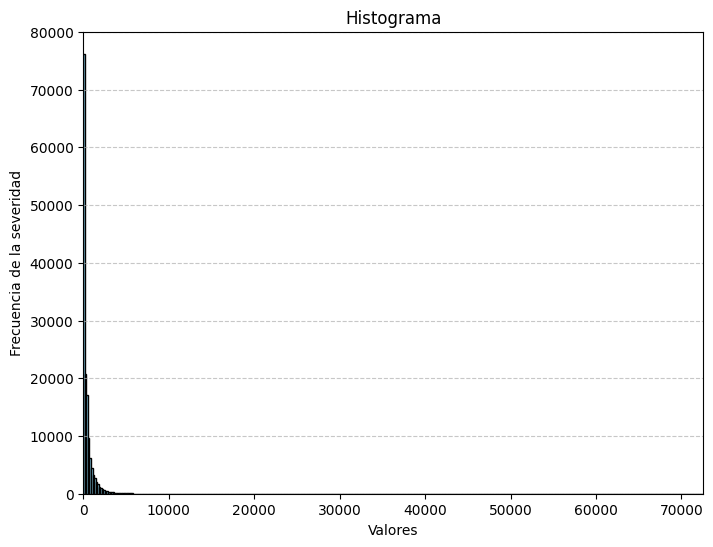

In [46]:
graficar_histograma(data,'coste_agregado', bins=400, titulo="Histograma", xlabel="Valores", ylabel="Frecuencia de la severidad", limite=max(data['coste_agregado']))

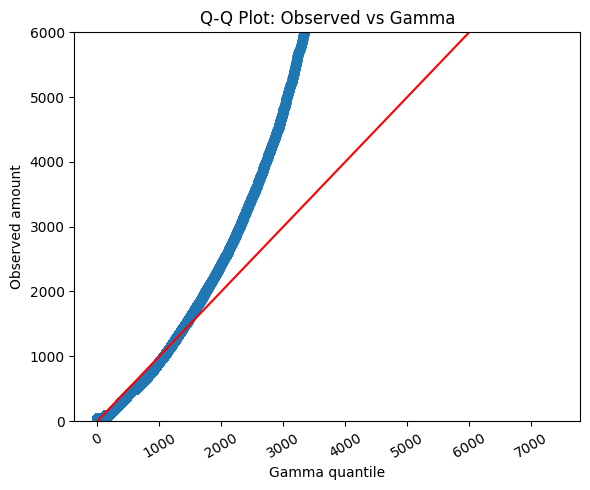

In [39]:
excess = data.coste_agregado[data.coste_agregado > 0] - 0

# Definir la distribución y ajustarla
dists = {'Gamma': ss.gamma}
fits = {k: v.fit(excess, floc=0) for k, v in dists.items()}

# Calcular los cuantiles observados
q_obs = excess.sort_values().values
nsin = len(q_obs)

# Calcular los cuantiles teóricos de la distribución ajustada
qteos = {k: v.ppf((np.arange(nsin) + 1) / (nsin + 1), *fits[k]) for k, v in dists.items()}

# Crear la figura y el único gráfico
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # Solo un gráfico en la fila

# Graficar el gráfico de la distribución Gamma
axs.scatter(qteos['Gamma'], q_obs)
axs.plot(qteos['Gamma'], qteos['Gamma'], color='r')

# Configuración del gráfico
axs.tick_params(axis='x', rotation=30)
axs.set_xlabel('Gamma quantile')
axs.set_ylabel('Observed amount')
axs.set_ylim(0, 6000)
axs.set_title('Q-Q Plot: Observed vs Gamma')

# Ajustar el diseño
fig.tight_layout()

# Mostrar el gráfico
plt.show()

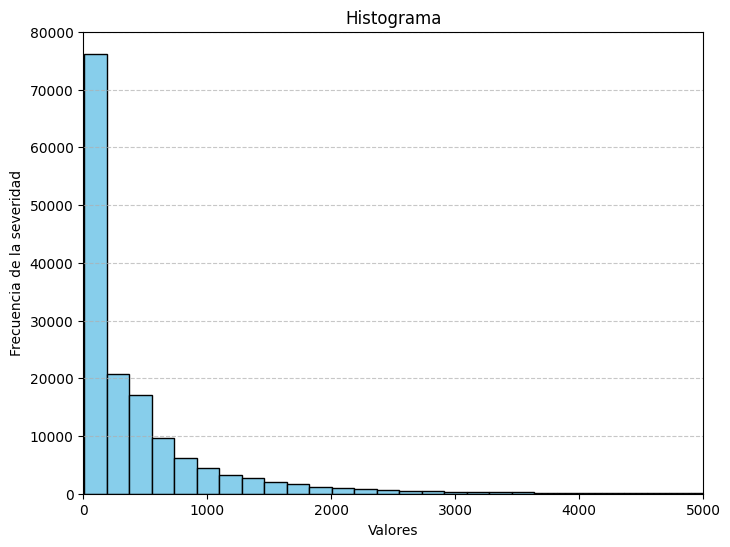

In [47]:
graficar_histograma(data,'coste_agregado', bins=400, titulo="Histograma", xlabel="Valores", ylabel="Frecuencia de la severidad", limite=5000)